# Notebook to create a standard load profile based on most recent data available

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [4]:
dynamic_factors = pd.read_csv('/Users/juliusbecker/Project_Energy_Tariffs/data/standard_profile/dynamic_factors.csv')
energy_usage = pd.read_csv('/Users/juliusbecker/Project_Energy_Tariffs/data/standard_profile/energy_usage.csv')

In [5]:
# Let's examine the structure of both files
print("Dynamic factors shape:", dynamic_factors.shape)
print("Dynamic factors columns:", dynamic_factors.columns.tolist())
print("\nFirst few rows of dynamic factors:")
print(dynamic_factors.head())

print("\n" + "="*50)
print("Energy usage shape:", energy_usage.shape)
print("Energy usage columns:", energy_usage.columns.tolist())
print("\nFirst few rows of energy usage:")
print(energy_usage.head())

Dynamic factors shape: (365, 3)
Dynamic factors columns: ['day-number', 'date', 'dynamic factor']

First few rows of dynamic factors:
   day-number   date  dynamic factor
0           1  1-Jan        1.242030
1           2  2-Jan        1.243922
2           3  3-Jan        1.245678
3           4  4-Jan        1.247299
4           5  5-Jan        1.248787

Energy usage shape: (97, 37)
Energy usage columns: ['Unnamed: 0', 'January', 'January.1', 'January.2', 'February', 'February.1', 'February.2', 'March', 'March.1', 'March.2', 'April', 'April.1', 'April.2', 'May', 'May.1', 'May.2', 'June', 'June.1', 'June.2', 'July', 'July.1', 'July.2', 'August', 'August.1', 'August.2', 'September', 'September.1', 'September.2', 'October', 'October.1', 'October.2', 'November', 'November.1', 'November.2', 'December', 'December.1', 'December.2']

First few rows of energy usage:
    Unnamed: 0 January January.1 January.2 February February.1 February.2  \
0          NaN      SA        FT        WT       SA  

In [ ]:
# Clean up the energy usage data
# First row contains the day type codes (SA, FT, WT), second row starts the actual data
day_types = energy_usage.iloc[0, 1:].values  # Get SA, FT, WT codes
energy_data = energy_usage.iloc[1:, :].copy()  # Get actual usage data
energy_data.columns = energy_usage.columns  # Keep original column names

# Set the time intervals as index
energy_data.set_index('Unnamed: 0', inplace=True)

print("Day types:", day_types)
print("Energy data shape:", energy_data.shape)
print("Energy data index (time intervals):")
print(energy_data.index[:10].tolist())

Day types: ['SA' 'FT' 'WT' 'SA' 'FT' 'WT' 'SA' 'FT' 'WT' 'SA' 'FT' 'WT' 'SA' 'FT'
 'WT' 'SA' 'FT' 'WT' 'SA' 'FT' 'WT' 'SA' 'FT' 'WT' 'SA' 'FT' 'WT' 'SA'
 'FT' 'WT' 'SA' 'FT' 'WT' 'SA' 'FT' 'WT']
Energy data shape: (96, 36)
Energy data index (time intervals):
['00:00-00:15', '00:15-00:30', '00:30-00:45', '00:45-01:00', '01:00-01:15', '01:15-01:30', '01:30-01:45', '01:45-02:00', '02:00-02:15', '02:15-02:30']


In [7]:
# Create datetime range from Jan 1, 2025 to end of 2026 in 15-minute intervals
start_date = datetime(2025, 1, 1)
end_date = datetime(2027, 1, 1)  # Go to start of 2027 to include all of 2026
datetime_range = pd.date_range(start=start_date, end=end_date, freq='15min', inclusive='left')

print(f"Total datetime points: {len(datetime_range)}")
print(f"First few dates: {datetime_range[:5]}")
print(f"Last few dates: {datetime_range[-5:]}")

# Verify we have 96 time intervals per day (24 hours * 4 intervals per hour)
print(f"Intervals per day: 24 hours * 4 = {24*4}")
print(f"Energy data has {len(energy_data)} time intervals per day")

Total datetime points: 70080
First few dates: DatetimeIndex(['2025-01-01 00:00:00', '2025-01-01 00:15:00',
               '2025-01-01 00:30:00', '2025-01-01 00:45:00',
               '2025-01-01 01:00:00'],
              dtype='datetime64[ns]', freq='15T')
Last few dates: DatetimeIndex(['2026-12-31 22:45:00', '2026-12-31 23:00:00',
               '2026-12-31 23:15:00', '2026-12-31 23:30:00',
               '2026-12-31 23:45:00'],
              dtype='datetime64[ns]', freq='15T')
Intervals per day: 24 hours * 4 = 96
Energy data has 96 time intervals per day


In [9]:
# Let's check the actual column structure after removing the first column
print("Energy data columns:", len(energy_data.columns))
print("Actual columns:", energy_data.columns.tolist())

# The energy data has 36 columns (excluding the index), which is 12 months * 3 day types = 36
# But we need to account for the fact that the first column (Unnamed: 0) is now the index
month_cols = {}
for i, month in enumerate(months):
    month_cols[month] = {
        'SA': energy_data.columns[i*3],      # Saturday  
        'FT': energy_data.columns[i*3 + 1],  # Sunday/Holiday (FT = Feiertag)
        'WT': energy_data.columns[i*3 + 2]   # Weekday (WT = Werktag)
    }

print("Month column mapping example for January:")
print(month_cols['January'])

Energy data columns: 36
Actual columns: ['January', 'January.1', 'January.2', 'February', 'February.1', 'February.2', 'March', 'March.1', 'March.2', 'April', 'April.1', 'April.2', 'May', 'May.1', 'May.2', 'June', 'June.1', 'June.2', 'July', 'July.1', 'July.2', 'August', 'August.1', 'August.2', 'September', 'September.1', 'September.2', 'October', 'October.1', 'October.2', 'November', 'November.1', 'November.2', 'December', 'December.1', 'December.2']
Month column mapping example for January:
{'SA': 'January', 'FT': 'January.1', 'WT': 'January.2'}


In [10]:
# Function to determine day type (SA=Saturday, FT=Sunday, WT=Weekday)
def get_day_type(date):
    weekday = date.weekday()  # Monday=0, Sunday=6
    if weekday == 5:  # Saturday
        return 'SA'
    elif weekday == 6:  # Sunday
        return 'FT'
    else:  # Monday-Friday
        return 'WT'

# Test the function
test_date = datetime(2025, 1, 1)  # Wednesday
print(f"Jan 1, 2025 ({test_date.strftime('%A')}) -> {get_day_type(test_date)}")

# Check day of year mapping in dynamic factors
print(f"Dynamic factors covers {len(dynamic_factors)} days")
print("Sample dynamic factors:")
print(dynamic_factors.head(10))

Jan 1, 2025 (Wednesday) -> WT
Dynamic factors covers 365 days
Sample dynamic factors:
   day-number    date  dynamic factor
0           1   1-Jan        1.242030
1           2   2-Jan        1.243922
2           3   3-Jan        1.245678
3           4   4-Jan        1.247299
4           5   5-Jan        1.248787
5           6   6-Jan        1.250145
6           7   7-Jan        1.251374
7           8   8-Jan        1.252476
8           9   9-Jan        1.253453
9          10  10-Jan        1.254306


In [11]:
# Create the standard load profile
def create_standard_load_profile():
    profile_data = []
    
    for dt in datetime_range:
        # Get the day of year (1-365 for non-leap years, 1-366 for leap years)
        day_of_year = dt.timetuple().tm_yday
        
        # For 2025 and 2026, we need to map to the 365-day dynamic factors cycle
        # Since dynamic_factors only has 365 days, we use modulo for leap years
        factor_index = (day_of_year - 1) % len(dynamic_factors)
        dynamic_factor = dynamic_factors.iloc[factor_index]['dynamic factor']
        
        # Get month name
        month_name = dt.strftime('%B')
        
        # Get day type
        day_type = get_day_type(dt)
        
        # Get the appropriate column for this month and day type
        col_name = month_cols[month_name][day_type]
        
        # Get time interval (00:00-00:15 format)
        time_str = dt.strftime('%H:%M') + '-' + (dt + timedelta(minutes=15)).strftime('%H:%M')
        
        # Find the matching row in energy_data for this time interval
        try:
            base_usage = float(energy_data.loc[time_str, col_name])
            # Apply dynamic factor
            final_usage = base_usage * dynamic_factor
            
            profile_data.append({
                'datetime': dt,
                'value': final_usage
            })
        except KeyError:
            # Handle edge case for 23:45-00:00 which might be represented differently
            if time_str == '23:45-00:00':
                time_str = '23:45-24:00'
                try:
                    base_usage = float(energy_data.loc[time_str, col_name])
                    final_usage = base_usage * dynamic_factor
                    profile_data.append({
                        'datetime': dt,
                        'value': final_usage
                    })
                except KeyError:
                    print(f"Warning: Could not find time interval {time_str}")
                    continue
            else:
                print(f"Warning: Could not find time interval {time_str}")
                continue
    
    return pd.DataFrame(profile_data)

# Generate the profile (this might take a moment)
print("Generating standard load profile...")
profile_df = create_standard_load_profile()
print(f"Generated {len(profile_df)} data points")
print("\nFirst few rows:")
print(profile_df.head(10))

Generating standard load profile...
Generated 70080 data points

First few rows:
             datetime      value
0 2025-01-01 00:00:00  24.997100
1 2025-01-01 00:15:00  23.493002
2 2025-01-01 00:30:00  22.305621
3 2025-01-01 00:45:00  21.365404
4 2025-01-01 01:00:00  20.632606
5 2025-01-01 01:15:00  19.968120
6 2025-01-01 01:30:00  19.619109
7 2025-01-01 01:45:00  19.003062
8 2025-01-01 02:00:00  18.986916
9 2025-01-01 02:15:00  18.808064


In [12]:
# Verify the data
print("Profile summary:")
print(f"Date range: {profile_df['datetime'].min()} to {profile_df['datetime'].max()}")
print(f"Total data points: {len(profile_df)}")
print(f"Expected data points: {2 * 365 * 96 + 96} (2 years * 365 days * 96 intervals + 96 for leap day)")
print(f"Value range: {profile_df['value'].min():.2f} to {profile_df['value'].max():.2f}")
print(f"Average value: {profile_df['value'].mean():.2f}")

# Check for any missing data
print(f"\nMissing values: {profile_df.isnull().sum().sum()}")

# Sample data from different periods
print("\nSample data from different time periods:")
print("January 1, 2025 (Wednesday):")
jan_1_data = profile_df[profile_df['datetime'].dt.date == datetime(2025, 1, 1).date()]
print(jan_1_data.head(8))

print("\nJanuary 4, 2025 (Saturday):")
jan_4_data = profile_df[profile_df['datetime'].dt.date == datetime(2025, 1, 4).date()]
print(jan_4_data.head(4))

print("\nJanuary 5, 2025 (Sunday):")
jan_5_data = profile_df[profile_df['datetime'].dt.date == datetime(2025, 1, 5).date()]
print(jan_5_data.head(4))

Profile summary:
Date range: 2025-01-01 00:00:00 to 2026-12-31 23:45:00
Total data points: 70080
Expected data points: 70176 (2 years * 365 days * 96 intervals + 96 for leap day)
Value range: 13.49 to 57.10
Average value: 28.52

Missing values: 0

Sample data from different time periods:
January 1, 2025 (Wednesday):
             datetime      value
0 2025-01-01 00:00:00  24.997100
1 2025-01-01 00:15:00  23.493002
2 2025-01-01 00:30:00  22.305621
3 2025-01-01 00:45:00  21.365404
4 2025-01-01 01:00:00  20.632606
5 2025-01-01 01:15:00  19.968120
6 2025-01-01 01:30:00  19.619109
7 2025-01-01 01:45:00  19.003062

January 4, 2025 (Saturday):
               datetime      value
288 2025-01-04 00:00:00  27.630163
289 2025-01-04 00:15:00  25.955040
290 2025-01-04 00:30:00  24.642882
291 2025-01-04 00:45:00  23.560227

January 5, 2025 (Sunday):
               datetime      value
384 2025-01-05 00:00:00  28.906927
385 2025-01-05 00:15:00  27.454588
386 2025-01-05 00:30:00  26.408104
387 2025-01-05

In [13]:
# Save the standard load profile to CSV
output_file = '/Users/juliusbecker/Project_Energy_Tariffs/data/Standard_Load_Profile_2025_2026.csv'
profile_df.to_csv(output_file, index=False)

print(f"Standard load profile saved to: {output_file}")
print(f"File contains {len(profile_df)} rows with datetime and value columns")

# Display final summary
print("\nFinal verification:")
print(f"Data covers: {profile_df['datetime'].dt.date.min()} to {profile_df['datetime'].dt.date.max()}")
print(f"Time intervals: 15-minute intervals from 00:00 to 23:45 each day")
print(f"Total days covered: {profile_df['datetime'].dt.date.nunique()}")
print(f"Unique months: {sorted(profile_df['datetime'].dt.month.unique())}")
print(f"Value statistics:")
print(f"  Min: {profile_df['value'].min():.2f}")
print(f"  Max: {profile_df['value'].max():.2f}")
print(f"  Mean: {profile_df['value'].mean():.2f}")
print(f"  Median: {profile_df['value'].median():.2f}")

# Show sample of the saved data
print(f"\nSample of saved data:")
print(profile_df.head())

Standard load profile saved to: /Users/juliusbecker/Project_Energy_Tariffs/data/Standard_Load_Profile_2025_2026.csv
File contains 70080 rows with datetime and value columns

Final verification:
Data covers: 2025-01-01 to 2026-12-31
Time intervals: 15-minute intervals from 00:00 to 23:45 each day
Total days covered: 730
Unique months: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Value statistics:
  Min: 13.49
  Max: 57.10
  Mean: 28.52
  Median: 27.14

Sample of saved data:
             datetime      value
0 2025-01-01 00:00:00  24.997100
1 2025-01-01 00:15:00  23.493002
2 2025-01-01 00:30:00  22.305621
3 2025-01-01 00:45:00  21.365404
4 2025-01-01 01:00:00  20.632606


Daily totals calculated for 730 days
Daily consumption range: 2219.7 to 3707.7
Average daily consumption: 2738.4


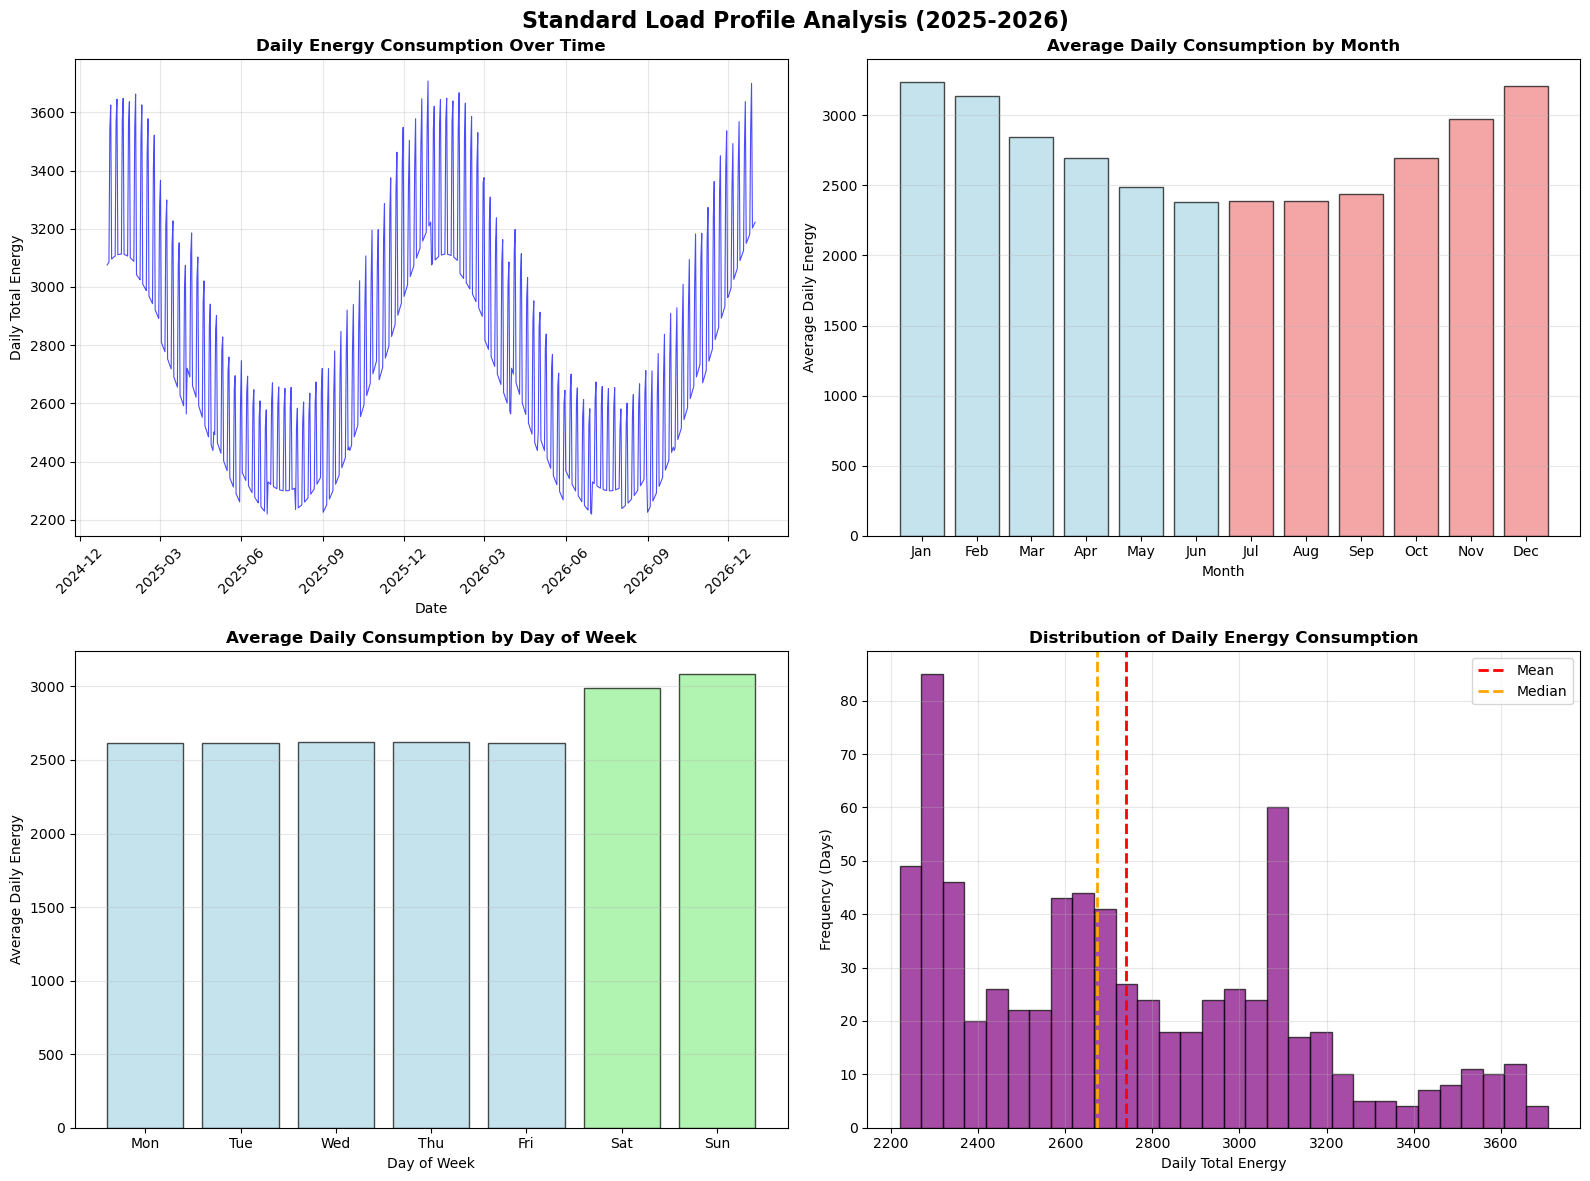

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

# Create daily aggregations for better visualization
daily_profile = profile_df.copy()
daily_profile['date'] = daily_profile['datetime'].dt.date
daily_profile['day_of_week'] = daily_profile['datetime'].dt.day_name()
daily_profile['month'] = daily_profile['datetime'].dt.month_name()

# Calculate daily totals
daily_totals = daily_profile.groupby('date').agg({
    'value': 'sum',
    'day_of_week': 'first',
    'month': 'first'
}).reset_index()

daily_totals['date'] = pd.to_datetime(daily_totals['date'])

print(f"Daily totals calculated for {len(daily_totals)} days")
print(f"Daily consumption range: {daily_totals['value'].min():.1f} to {daily_totals['value'].max():.1f}")
print(f"Average daily consumption: {daily_totals['value'].mean():.1f}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Standard Load Profile Analysis (2025-2026)', fontsize=16, fontweight='bold')

# Plot 1: Time series of daily totals
axes[0, 0].plot(daily_totals['date'], daily_totals['value'], linewidth=0.8, alpha=0.7, color='blue')
axes[0, 0].set_title('Daily Energy Consumption Over Time', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Daily Total Energy')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Monthly averages comparison
monthly_avg = daily_totals.groupby(daily_totals['date'].dt.month)['value'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['lightblue' if i < 6 else 'lightcoral' for i in range(12)]
axes[0, 1].bar(range(1, 13), monthly_avg.values, color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Average Daily Consumption by Month', fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Daily Energy')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_names)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Day of week patterns
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg = daily_totals.groupby('day_of_week')['value'].mean().reindex(day_order)
weekend_colors = ['lightgreen' if day in ['Saturday', 'Sunday'] else 'lightblue' for day in day_order]
axes[1, 0].bar(range(7), dow_avg.values, color=weekend_colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Average Daily Consumption by Day of Week', fontweight='bold')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Average Daily Energy')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels([day[:3] for day in day_order])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Distribution histogram
axes[1, 1].hist(daily_totals['value'], bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(daily_totals['value'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1, 1].axvline(daily_totals['value'].median(), color='orange', linestyle='--', linewidth=2, label='Median')
axes[1, 1].set_title('Distribution of Daily Energy Consumption', fontweight='bold')
axes[1, 1].set_xlabel('Daily Total Energy')
axes[1, 1].set_ylabel('Frequency (Days)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

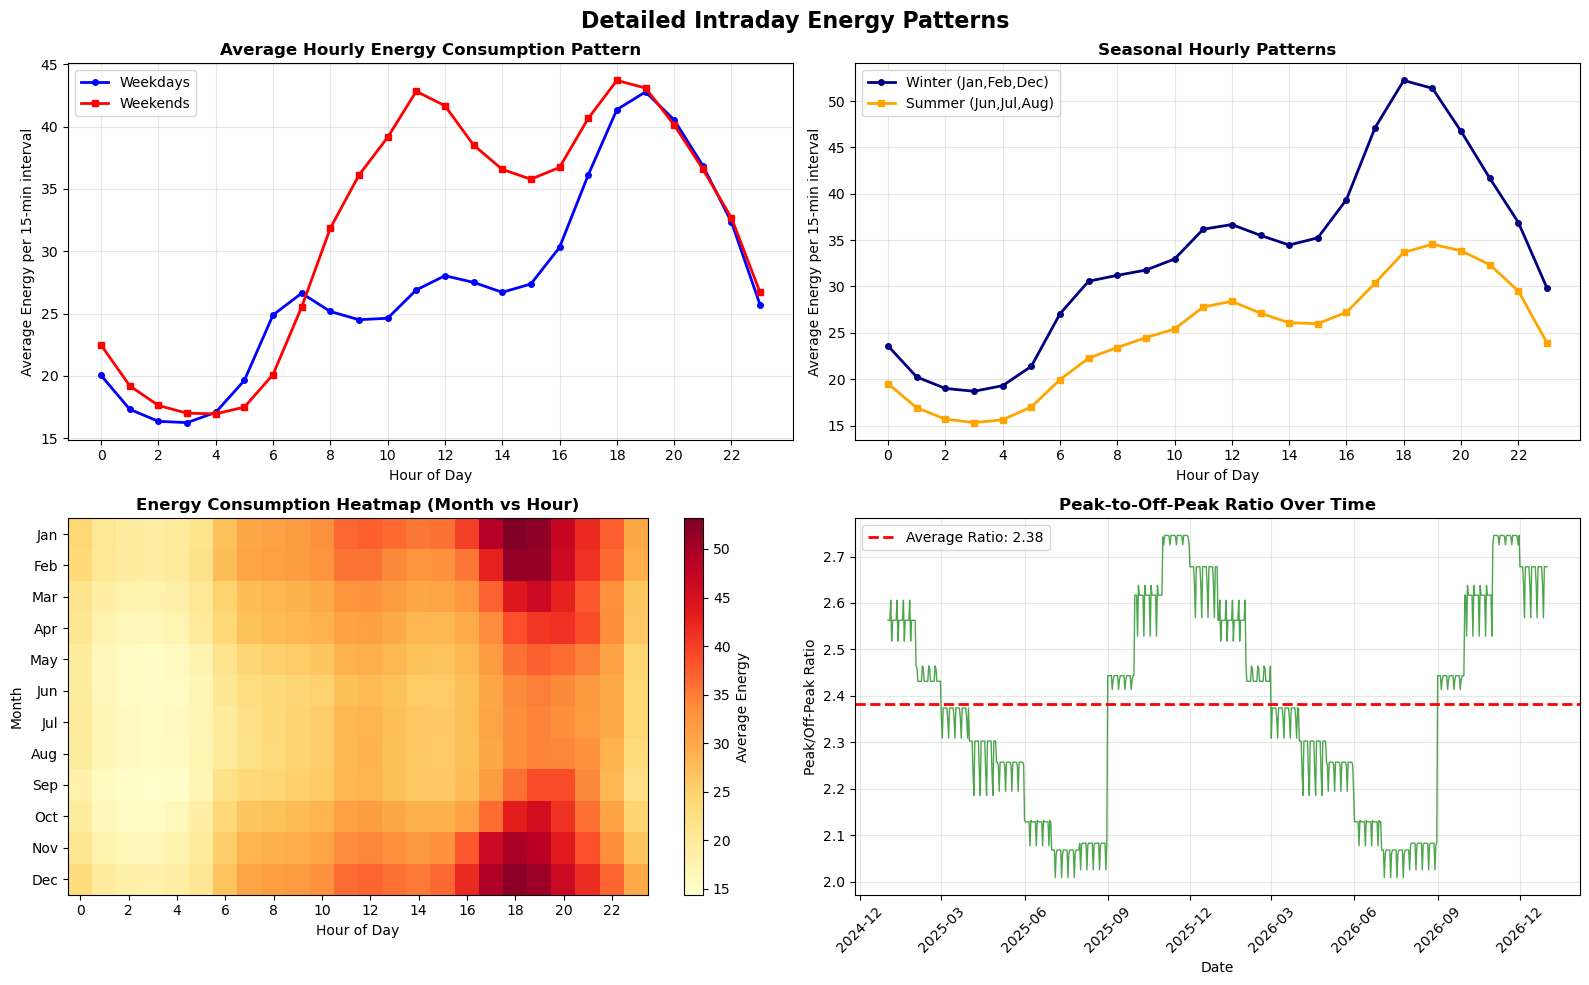


LOAD PROFILE INSIGHTS
Peak consumption typically occurs around: 19:00
Lowest consumption typically occurs around: 3:00
Weekend vs Weekday difference: 4.3 (weekend higher)
Winter vs Summer difference: 8.4 (winter higher)
Average peak-to-off-peak ratio: 2.38
Highest daily consumption: 3707.7 on 2025-12-28 00:00:00
Lowest daily consumption: 2219.7 on 2025-06-30 00:00:00


In [15]:
# Additional visualization: Intraday patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Detailed Intraday Energy Patterns', fontsize=16, fontweight='bold')

# Create hourly averages for different day types
hourly_profile = profile_df.copy()
hourly_profile['hour'] = hourly_profile['datetime'].dt.hour
hourly_profile['day_type'] = hourly_profile['datetime'].dt.day_name()
hourly_profile['is_weekend'] = hourly_profile['day_type'].isin(['Saturday', 'Sunday'])
hourly_profile['month'] = hourly_profile['datetime'].dt.month

# Plot 1: Average hourly pattern by day type
weekday_hourly = hourly_profile[~hourly_profile['is_weekend']].groupby('hour')['value'].mean()
weekend_hourly = hourly_profile[hourly_profile['is_weekend']].groupby('hour')['value'].mean()

axes[0, 0].plot(weekday_hourly.index, weekday_hourly.values, 'b-', linewidth=2, label='Weekdays', marker='o', markersize=4)
axes[0, 0].plot(weekend_hourly.index, weekend_hourly.values, 'r-', linewidth=2, label='Weekends', marker='s', markersize=4)
axes[0, 0].set_title('Average Hourly Energy Consumption Pattern', fontweight='bold')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Average Energy per 15-min interval')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(0, 24, 2))

# Plot 2: Seasonal hourly patterns (winter vs summer)
winter_months = [1, 2, 12]  # Jan, Feb, Dec
summer_months = [6, 7, 8]   # Jun, Jul, Aug

winter_hourly = hourly_profile[hourly_profile['month'].isin(winter_months)].groupby('hour')['value'].mean()
summer_hourly = hourly_profile[hourly_profile['month'].isin(summer_months)].groupby('hour')['value'].mean()

axes[0, 1].plot(winter_hourly.index, winter_hourly.values, 'navy', linewidth=2, label='Winter (Jan,Feb,Dec)', marker='o', markersize=4)
axes[0, 1].plot(summer_hourly.index, summer_hourly.values, 'orange', linewidth=2, label='Summer (Jun,Jul,Aug)', marker='s', markersize=4)
axes[0, 1].set_title('Seasonal Hourly Patterns', fontweight='bold')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Average Energy per 15-min interval')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(0, 24, 2))

# Plot 3: Heatmap of average consumption by hour and month
monthly_hourly = hourly_profile.groupby(['month', 'hour'])['value'].mean().unstack()
im = axes[1, 0].imshow(monthly_hourly.values, aspect='auto', cmap='YlOrRd', interpolation='nearest')
axes[1, 0].set_title('Energy Consumption Heatmap (Month vs Hour)', fontweight='bold')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Month')
axes[1, 0].set_xticks(range(0, 24, 2))
axes[1, 0].set_xticklabels(range(0, 24, 2))
axes[1, 0].set_yticks(range(12))
axes[1, 0].set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.colorbar(im, ax=axes[1, 0], label='Average Energy')

# Plot 4: Peak and off-peak analysis
peak_hours = [17, 18, 19, 20]  # 5-8 PM
off_peak_hours = [1, 2, 3, 4]  # 1-4 AM

peak_daily = hourly_profile[hourly_profile['hour'].isin(peak_hours)].groupby(hourly_profile['datetime'].dt.date)['value'].mean()
off_peak_daily = hourly_profile[hourly_profile['hour'].isin(off_peak_hours)].groupby(hourly_profile['datetime'].dt.date)['value'].mean()

peak_off_peak_ratio = peak_daily / off_peak_daily
peak_off_peak_ratio.index = pd.to_datetime(peak_off_peak_ratio.index)

axes[1, 1].plot(peak_off_peak_ratio.index, peak_off_peak_ratio.values, 'green', linewidth=1, alpha=0.7)
axes[1, 1].axhline(peak_off_peak_ratio.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Average Ratio: {peak_off_peak_ratio.mean():.2f}')
axes[1, 1].set_title('Peak-to-Off-Peak Ratio Over Time', fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Peak/Off-Peak Ratio')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axes[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print some interesting statistics
print("\n" + "="*60)
print("LOAD PROFILE INSIGHTS")
print("="*60)
print(f"Peak consumption typically occurs around: {weekday_hourly.idxmax()}:00")
print(f"Lowest consumption typically occurs around: {weekday_hourly.idxmin()}:00")
print(f"Weekend vs Weekday difference: {weekend_hourly.mean() - weekday_hourly.mean():.1f} (weekend higher)" if weekend_hourly.mean() > weekday_hourly.mean() else f"Weekend vs Weekday difference: {weekday_hourly.mean() - weekend_hourly.mean():.1f} (weekday higher)")
print(f"Winter vs Summer difference: {winter_hourly.mean() - summer_hourly.mean():.1f} (winter higher)" if winter_hourly.mean() > summer_hourly.mean() else f"Winter vs Summer difference: {summer_hourly.mean() - winter_hourly.mean():.1f} (summer higher)")
print(f"Average peak-to-off-peak ratio: {peak_off_peak_ratio.mean():.2f}")
print(f"Highest daily consumption: {daily_totals['value'].max():.1f} on {daily_totals.loc[daily_totals['value'].idxmax(), 'date']}")
print(f"Lowest daily consumption: {daily_totals['value'].min():.1f} on {daily_totals.loc[daily_totals['value'].idxmin(), 'date']}")